In [45]:
######################
#import useful modules
######################

import sys

sys.path.append("/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/") 

from Modules import *

from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText


########

%matplotlib inline


In [224]:

folder = './'

#################################################=
# coordinates for vertical sections

lon = np.arange(-50, -40, 0.1)
lats = [24]

time = 10080


#####

add_rho = True
add_ct_sa = True
using_t = False

season = 'annual'

#####

lon0 = np.mean(lon)
lat0 = np.mean(lats)

sectionname = '_' + format(lats[section]) + 'N.'; label = format(lats[section]) + 'N'

lat = lon * 0. + lats[section];
maxdepth = -5000; xliml = np.min(lon); xlimr = np.max(lon)
lon1, lon2 = np.min(lon)-1,np.max(lon)+1
        
####

def find_nearest(x,y,lon, lat):
    dist = (x-lon)**2 + (y-lat)**2
    return np.unravel_index(dist.argmin(),dist.shape)

#################################################=


simul = load(simul = 'gigatl3_1h_tides', time = time);
i0,j0 = find_nearest(simul.x,simul.y,lon0, lat0); print(i0,j0)

# Load ZOOM
dx = 200; dy = 200
simul = load(simul = 'gigatl3_1h_tides' + ' [' + format(j0-dy) + ',' + format(j0+dy)\
                                   +  ',' + format(i0-dx) + ',' + format(i0+dx) + ',[1,300,1]] ' + format(time));


#################################################

[x,y] = np.mgrid[:simul.x.shape[0],:simul.x.shape[1]]

x0new  = interp.griddata((simul.x.ravel(),simul.y.ravel()),x.ravel(),(lon,lat),method='cubic')
y0new = interp.griddata((simul.x.ravel(),simul.y.ravel()),y.ravel(),(lon,lat),method='cubic')

###################################################################################
# find corresponding indices
###################################################################################

# gives only closest value
#xsec,ysec = tools.find_points(simul.x,simul.y, np.array(lon),np.array(lat))

[x,y] = np.mgrid[:simul.x.shape[0],:simul.x.shape[1]]

x0new  = interp.griddata((simul.x.ravel(),simul.y.ravel()),x.ravel(),(lon,lat),method='cubic')
y0new = interp.griddata((simul.x.ravel(),simul.y.ravel()),y.ravel(),(lon,lat),method='cubic')

###########################

imean = np.arange(np.floor(np.min(x0new))-1,np.ceil(np.max(x0new))+2)
poly = interp.interp1d(x0new,y0new,kind='linear',bounds_error=False,fill_value='extrapolate');

jmean = poly(imean)

#py.plot(x0new,y0new,'-o',); py.plot(imean,jmean,linewidth=3); py.show()

oldjmean = copy(jmean)

############################


x_0,sizex = np.int(imean[0]),-1

lonpsi = simul.x[x_0+1:sizex,:]
latpsi = simul.y[x_0+1:sizex,:]

###################################################################################
# Define the new coordinates based on refined pos
###################################################################################

angle = sm.angle(jmean)

#Temporay test to cath the z=-50 isobath all the way
Ly = 10;

###########

py.plot(imean,jmean,'-g'); py.contourf(simul.topo.T,100);
py.plot(imean,oldjmean,'-k',lw=4.);
#py.plot(imean,jmean-Ly,'--g'); py.plot(imean,jmean+Ly,'--g');
py.savefig(fifig+'test.png',magnification='auto', dpi=250,bbox_inches='tight',transparence='true'); py.clf()

###########

[elem,coef,newXrot,newYrot] = sm.transform_grid(jmean,angle,simul.x[x_0+1:sizex,:].shape[1],Ly)

print('transformation OK')

###################################################################################

newlon = np.sum(coef*lonpsi.ravel()[elem],2)
newlat = np.sum(coef*latpsi.ravel()[elem],2)

###################################################################################
#Plot transport
###################################################################################

toporot = np.sum(coef*simul.topo[x_0+1:sizex,:].ravel()[elem],2) #*maskrot
iy=Ly;

nx = toporot[:,iy].shape[0]

#####################

myvar = var('temp',simul).data

lon_mod = np.zeros((toporot.shape[0],myvar.shape[-1]))

for iz in range(myvar.shape[-1]):
    lon_mod[:,iz] = newlon[:,iy]

lon_mod = lon_mod.T
#####################



##################################################################################
# TIME LOOP
###################################################################################

simul.update(time)

filename = folder + simul.simul + label  + '.nc'
if using_t: filename = folder + simul.simul+ '_using_t' + label  + '.nc'


##########

[z_r,z_w] = tools.get_depths(simul)

myvar = var('temp',simul).data
salt = var('salt',simul).data
u0 = tools.u2rho(var('u',simul).data)
v0 = tools.v2rho(var('v',simul).data)
if add_rho: rho1 = var('rho1',simul).data + simul.rho0 - 1000.

for iz in range(u0.shape[-1]):
    [u0[:,:,iz],v0[:,:,iz]] = tools.rotuv(simul,u0[:,:,iz],v0[:,:,iz],psi=False)

###########

temprot = np.zeros((toporot.shape[0],toporot.shape[1],myvar.shape[-1]))
saltrot = np.zeros((toporot.shape[0],toporot.shape[1],myvar.shape[-1]))
urot = np.zeros((toporot.shape[0],toporot.shape[1],myvar.shape[-1]))
vrot = np.zeros((toporot.shape[0],toporot.shape[1],myvar.shape[-1]))
zrot =  np.zeros((toporot.shape[0],toporot.shape[1],myvar.shape[-1]))
if add_rho: rho1rot = np.zeros((toporot.shape[0],toporot.shape[1],myvar.shape[-1]))


nz = temprot.shape[-1]

for iz in range(nz):
    temprot[:,:,iz] = np.sum(coef*myvar[x_0+1:sizex,:,iz].ravel()[elem],2)
    saltrot[:,:,iz] = np.sum(coef*salt[x_0+1:sizex,:,iz].ravel()[elem],2)
    urot[:,:,iz] = np.sum(coef*u0[x_0+1:sizex,:,iz].ravel()[elem],2)
    vrot[:,:,iz] = np.sum(coef*v0[x_0+1:sizex,:,iz].ravel()[elem],2)
    zrot[:,:,iz] = np.sum(coef*z_r[x_0+1:sizex,:,iz].ravel()[elem],2)
    if add_rho: rho1rot[:,:,iz] = np.sum(coef*rho1[x_0+1:sizex,:,iz].ravel()[elem],2)

#######

temprot = temprot[:,iy,:]
saltrot = saltrot[:,iy,:]
urot = urot[:,iy,:]
vrot = vrot[:,iy,:]
zrot = zrot[:,iy,:]
if add_rho: rho1rot = rho1rot[:,iy,:]

#######
if add_ct_sa:
    import gsw
    p = gsw.p_from_z(zrot,np.nanmean(newlat))
    SA_mod = gsw.SA_from_SP(saltrot,p,np.nanmean(newlon),np.nanmean(newlat))

    if using_t:
        CT_mod = gsw.CT_from_t(SA_mod,temprot,p)
    else:
        CT_mod = gsw.CT_from_pt(SA_mod,temprot)

    rho_gsw = gsw.rho(SA_mod,CT_mod,0) - 1000.

    
    
### for plotting

topo = toporot[:,iy].T
depth_mod = zrot.T

CT_mod = CT_mod.T
SA_mod = SA_mod.T
rho_mod = rho_gsw.T

simulname is None
args (['gigatl3_1h_tides'],)
args[0] ['gigatl3_1h_tides']
len(args[0]) 1
coord
loading /net/libra/local/tmp/1//gula/ROMS/Simulations/GIGATL/GIGATL3/gigatl3_grd.nc
loading /net/omega/local/tmp/1/gula/GIGATL3/GIGATL3_1h_tides/GIGATL3_3h_inst_2007-06-28-2007-07-02.nc
get domain [0,10000,0,10000,[1,1000,1]] [0,10
coordmax
loading /net/libra/local/tmp/1//gula/ROMS/Simulations/GIGATL/GIGATL3/gigatl3_grd.nc
loading /net/omega/local/tmp/1/gula/GIGATL3/GIGATL3_1h_tides/GIGATL3_3h_inst_2007-06-28-2007-07-02.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in grdfile.variables
no Zob in job ... using Zob = 0.01
dt
dt is read in  /net/omega/local/tmp/1/gula/GIGATL3/GIGATL3_1h_tides/GIGATL3_3h_inst_2007-06-28-2007-07-02.nc
[0, 4002, 0, 3002, array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  

/home/gula/.virtualenvs/paragridded/lib/python3.6/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/gula/.virtualenvs/paragridded/lib/python3.6/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparence" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/R_smooth.py:437: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p[i,:] = np.linalg.lstsq(A.T,B.T)[0]


transformation OK
('gigatl3_1h_tides', '10080')
self.time is  10080
/net/omega/local/tmp/1/gula/GIGATL3/GIGATL3_1h_tides/GIGATL3_3h_inst_2007-06-28-2007-07-02.nc
depths [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] 1 rho1


<Figure size 432x288 with 0 Axes>

In [225]:
data = 'woa18'

#################
if 'woa' in data:

    ##########################
    # for WOA
    ##########################
    seasons=\
        {'annual': ['00',4],\
         'winter': ['13',0],\
         'spring': ['14',1],\
         'summer': ['15',2],\
         'fall': ['16',3]}

    if data=='woa18_mat': period = 'decav'; version = '_04' #average of all decades
    elif data=='woa13': period = 'decav'; version = '_04v2' #average of all decades
    elif data=='woa18': period = 'decav'; version = '_04' #average of all decades

    which_var = 'an' # 'mn' = binned, 'an' = objectively analyzed

    whicht='t_' + which_var
    whichs='s_' + which_var

    ############################

    #for season in ['annual']: #,'winter']:

    figname = data + '_' + which_var  +  '_' + period +  '_' + season

    if ct_exact: figname = figname + '_rho_ct_exact_'

    ###################################################################################
    # WOA data
    ###################################################################################

    if 'mat' in data:
        filename = "/net/krypton/data0/project/meddle/lecorre/OBS/WOA/woa18_decav_t00_04.nc"
    else:
        filename = "/home/gula/libra/OBS/WOA/" + data + "_"+ period + "_t" + seasons[season][0] + version + ".nc"

    ncfile =  Dataset(filename, 'r', format='NETCDF3_CLASSIC')
    lon_woa = simul.Forder(ncfile.variables['lon_bnds'][:])
    lat_woa = simul.Forder(ncfile.variables['lat_bnds'][:])
    depth =  ncfile.variables['depth'][:]

    # Select subdomain for faster computation
    x1 = np.nanargmin(np.abs(lon_woa-lon1))-2
    x2 = np.nanargmin(np.abs(lon_woa-lon2))+2
    y1 = np.nanargmin(np.abs(lat_woa-np.nanmin(simul.y)))-2
    y2 = np.nanargmin(np.abs(lat_woa-np.nanmax(simul.y)))+2

    lon_woa = 0.5*(lon_woa[0,x1:x2]+lon_woa[1,x1:x2])
    lat_woa = 0.5*(lat_woa[0,y1:y2]+lat_woa[1,y1:y2])
    [woa_y,woa_x] = np.meshgrid(lat_woa,lon_woa)

    t_woa = simul.Forder(ncfile.variables[whicht][:])[x1:x2,y1:y2,:,0]
    tmask = simul.Forder(ncfile.variables['t_dd'][:])[x1:x2,y1:y2,:,0]
    t_woa[t_woa>100] = np.nan
    ncfile.close()

    ####################

    if 'mat' in data:
        filename_S = "/net/krypton/data0/project/meddle/lecorre/OBS/WOA/woa18_decav_s00_04.nc"
    else:
        filename_S = "/home/gula/libra/OBS/WOA/" + data + "_"+ period + "_s" + seasons[season][0] + version + ".nc"
    ncfile =  Dataset(filename_S, 'r', format='NETCDF3_CLASSIC')

    s_woa = simul.Forder(ncfile.variables[whichs][:])[x1:x2,y1:y2,:,0]
    smask = simul.Forder(ncfile.variables['s_dd'][:])[x1:x2,y1:y2,:,0]
    s_woa[s_woa>100] = np.nan
    ncfile.close()

    # need woa_x, woa_y, t_woa, s_woa

###################################################################################

elif 'isas' in data:

    figname = data + '_' + season

    ###################################################################################
    # ISAS data
    ###################################################################################

    if 'mat' in data:
        filename = "/net/krypton/data0/project/meddle/lecorre/OBS/ISAS/TRC/mean_temp_2002_2008.nc"
    elif season=='annual':
        filename = "/net/alpha/exports/sciences/data/LPO_ISAS/CLIM_ISAS15_DM/ISAS15_DMFD_S_ann_TEMP.nc"
    elif season=='winter':
        filename = "/home/gula/libra/OBS/ISAS/ISAS15_DMFD_winter_TEMP.nc"




    ncfile =  Dataset(filename, 'r', format='NETCDF3_CLASSIC')
    lon_woa = simul.Forder(ncfile.variables['longitude'][:])
    lat_woa = simul.Forder(ncfile.variables['latitude'][:])
    depth =  ncfile.variables['depth'][:]

    # Select subdomain for faster computation
    x1 = np.nanargmin(np.abs(lon_woa-lon1))-2
    x2 = np.nanargmin(np.abs(lon_woa-lon2))+2
    y1 = np.nanargmin(np.abs(lat_woa-np.nanmin(simul.y)))-2
    y2 = np.nanargmin(np.abs(lat_woa-np.nanmax(simul.y)))+2

    [woa_y,woa_x] = np.meshgrid(lat_woa[y1:y2],lon_woa[x1:x2])

    t_woa = simul.Forder(ncfile.variables['TEMP'][:])[x1:x2,y1:y2,:,0]
    #t_woa =  t_woa * ncfile.variables['TEMP'].scale_factor + ncfile.variables['TEMP'].add_offset
    t_woa[t_woa>100] = np.nan
    ncfile.close()

    ################

    if 'mat' in data:
        filename = "/net/krypton/data0/project/meddle/lecorre/OBS/ISAS/TRC/mean_salt_2002_2008.nc"
    elif season=='annual':
        filename = "/net/alpha/exports/sciences/data/LPO_ISAS/CLIM_ISAS15_DM/ISAS15_DMFD_S_ann_PSAL.nc"
    elif season=='winter':
        filename = "/home/gula/libra/OBS/ISAS/ISAS15_DMFD_winter_PSAL.nc"

    ncfile =  Dataset(filename, 'r', format='NETCDF3_CLASSIC')
    s_woa = simul.Forder(ncfile.variables['PSAL'][:])[x1:x2,y1:y2,:,0]
    #s_woa =  s_woa * ncfile.variables['PSAL'].scale_factor + ncfile.variables['PSAL'].add_offset
    s_woa[s_woa>100] = np.nan
    ncfile.close()

###################################################################################

elif 'soda' in data:

    figname = data + '_' + season

    ###################################################################################
    # ISAS data
    ###################################################################################

    if season=='annual':
        if '2011' in data:
            filename = "/home/gula/libra/OBS/SODA/soda3.4.2_mn_ocean_reg_2011-2011.nc"
        else:
            filename = "/home/gula/libra/OBS/SODA/soda3.4.2_mn_ocean_reg_2002-2008.nc"
        itime=0
    elif season=='winter':
        if '2011' in data:
            filename = "/home/gula/libra/OBS/SODA/soda3.4.2_mn_ocean_reg_2011_winter.nc"
        itime = 0

    ncfile =  Dataset(filename, 'r', format='NETCDF3_CLASSIC')
    lon_woa = simul.Forder(ncfile.variables['xt_ocean'][:])-360.
    lat_woa = simul.Forder(ncfile.variables['yt_ocean'][:])
    depth =  ncfile.variables['st_ocean'][:]

    # Select subdomain for faster computation
    x1 = np.nanargmin(np.abs(lon_woa-lon1))-2
    x2 = np.nanargmin(np.abs(lon_woa-lon2))+2
    y1 = np.nanargmin(np.abs(lat_woa-np.nanmin(simul.y)))-2
    y2 = np.nanargmin(np.abs(lat_woa-np.nanmax(simul.y)))+2

    [woa_y,woa_x] = np.meshgrid(lat_woa[y1:y2],lon_woa[x1:x2])

    t_woa = simul.Forder(ncfile.variables['temp'][:])[x1:x2,y1:y2,:,itime]
    #t_woa =  t_woa * ncfile.variables['TEMP'].scale_factor + ncfile.variables['TEMP'].add_offset
    t_woa[t_woa<-100] = np.nan

    ################

    s_woa = simul.Forder(ncfile.variables['salt'][:])[x1:x2,y1:y2,:,itime]
    #s_woa =  s_woa * ncfile.variables['PSAL'].scale_factor + ncfile.variables['PSAL'].add_offset
    s_woa[s_woa<-100] = np.nan

    ################

    rho_woa = simul.Forder(ncfile.variables['prho'][:])[x1:x2,y1:y2,:,itime]
    rho_woa[rho_woa<-100] = np.nan




####################
# Interpolation of data
####################

[x,y] = np.mgrid[:t_woa.shape[0],:t_woa.shape[1]]

x0new = interp.griddata((woa_x.ravel(),woa_y.ravel()),x.ravel(),(lon,lat),method='cubic')
y0new = interp.griddata((woa_x.ravel(),woa_y.ravel()),y.ravel(),(lon,lat),method='cubic')

###########################

imean = np.arange(np.floor(np.min(x0new))-1,np.ceil(np.max(x0new))+2)
poly = interp.interp1d(x0new,y0new,kind='linear',bounds_error=False,fill_value='extrapolate');

jmean = poly(imean); oldjmean = copy(jmean)

############################

x_0,sizex = np.int(imean[0]),-1

lonpsi = woa_x[x_0+1:sizex,:]
latpsi = woa_x[x_0+1:sizex,:]

###################################################################################
# Define the new coordinates based on refined pos
###################################################################################

angle = sm.angle(jmean)

#Temporay test to cath the z=-50 isobath all the way
Ly = 10;
iy=Ly;

###########

py.plot(imean,jmean,'-g'); py.contourf(simul.topo.T,100);
py.plot(imean,oldjmean,'-k',lw=4.);
#py.plot(imean,jmean-Ly,'--g'); py.plot(imean,jmean+Ly,'--g');
py.savefig(fifig+'test.png',magnification='auto', dpi=250,bbox_inches='tight',transparence='true'); py.clf()

###########

[elem,coef,newXrot,newYrot] = sm.transform_grid(jmean,angle,woa_x[x_0+1:sizex,:].shape[1],Ly)

print('transformation OK')

###################################################################################

newlon = np.sum(coef*lonpsi.ravel()[elem],2)
newlat = np.sum(coef*latpsi.ravel()[elem],2)

nz = len(depth)

###################################################################################

xstream = np.zeros((newlon.shape[0],nz+1))
xstream[:,-1] = newlon[:,iy]

for iz in range(nz):
    xstream[:,iz] = newlon[:,iy]

#####################
# Interpolate Data
#####################

t_woa_rot = np.zeros((newlon.shape[0],newlon.shape[1],nz))
s_woa_rot = np.zeros((newlon.shape[0],newlon.shape[1],nz))

for iz in range(len(depth)):
    t_woa_rot[:,:,iz] = np.sum(coef*t_woa[x_0+1:sizex,:,iz].ravel()[elem],2)
    s_woa_rot[:,:,iz] = np.sum(coef*s_woa[x_0+1:sizex,:,iz].ravel()[elem],2)


#####################

'''
ilat = np.nanargmin(np.abs(lat-mylat))
print(lat[ilat])
mylat0 = lat[ilat]

t_woa = t_woa[:,ilat,:]
s_woa = s_woa[:,ilat,:]
'''

t_woa = t_woa_rot[:,iy,:]
s_woa = s_woa_rot[:,iy,:]

####################

p = gsw.p_from_z(-depth,np.nanmean(newlat))
SA_woa = gsw.SA_from_SP(s_woa,p,np.nanmean(newlon),np.nanmean(newlat))

if 'soda' in data:
    CT_woa = gsw.CT_from_pt(SA_woa,t_woa)
    pt_woa = t_woa
else:
    CT_woa = gsw.CT_from_t(SA_woa,t_woa,p)
    pt_woa = gsw.pt_from_t(SA_woa,t_woa,p,0)

#alternative
if ct_exact:
    rho_gsw = gsw.rho_t_exact(SA_woa,t_woa,0) - 1000.
else:
    rho_gsw = gsw.rho(SA_woa,CT_woa,0) - 1000.



###################################################################################
# fields are p, SA, CT, pt_woa, rho_gsw, newlon, newlat,


lon_woa = newlon[:,iy]

CT_woa =  CT_woa.T
SA_woa =  SA_woa.T
rho_woa =  rho_gsw.T

/home/gula/.virtualenvs/paragridded/lib/python3.6/site-packages/ipykernel_launcher.py:220: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/gula/.virtualenvs/paragridded/lib/python3.6/site-packages/ipykernel_launcher.py:220: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparence" which is no longer supported as of 3.3 and will become an error two minor releases later


transformation OK


/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/R_smooth.py:437: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p[i,:] = np.linalg.lstsq(A.T,B.T)[0]


<Figure size 432x288 with 0 Axes>

In [226]:
'''
###################################################################################

z = -1*depth

'''
y_coord = np.arange(pt_woa.shape[0]) * 1/np.mean(simul.pm)/1000.
y_coord = y_coord.max() - y_coord
y_coordz=lon
'''

y_coordz = newlon[:,iy]

###################################################################################
# PLOT
###################################################################################

cbarlabelsize = 6
fontsize0 = 12
fontsize1 = 16
fontsize2 = format(22)
fontsize3 = format(28)
font = {'size'   : fontsize1}
py.rc('font', **font)

for varname in ['ct','temp','SA','salt']:

    ###################################################################################

    if varname in ['ct','temp']:
        my_cmap=plot.ncview_colormap('jaisnc')
        levels= np.arange(3.,12.,0.5)
    else:
        my_cmap=plot.ncview_colormap('jaisnb')
        levels= np.arange(35.,35.8,0.02)

    if varname in ['ct']:
        varunit = 'CT [$^{\circ}$C]'
        myvar = CT; myrho = rho_gsw
    elif varname in ['temp']:
        varunit = 'T [$^{\circ}$C]'
        myvar = pt_woa; myrho = rho_gsw
    elif varname in ['SA']:
        varunit = 'AS'
        myvar = SA; myrho = rho_gsw
    elif varname in ['salt']:
        varunit = 'S'
        myvar = s_woa; myrho = rho_gsw

    ################################

    if section in [1,2]: fig = py.figure(figsize=(4.0,6.0))
    else: fig = py.figure(figsize=(7.0,6.0))
    ax = fig.add_subplot(111,facecolor='Gainsboro')

    ################################

    joe = ax.contourf(y_coordz, -depth, myvar.T, levels,extend='both', cmap=my_cmap)


    CS2 = ax.contour(y_coordz, -depth, myrho.T ,np.arange(0,30,0.1),colors = ('k',), linewidths = (1.,))
    py.clabel(CS2, fmt = '%2.1f', colors = 'k', fontsize=12)  ;

    #if section in [1,2]:
    #    for i in range(len(lon)):
    #        py.plot([lon[i],lon[i]],[-3050,-3000],'-k',lw=2.)


    #ax.plot(xstream[:,0],-toporot[:,iy],'-k',lw=2.)
    py.xlabel('lon',fontsize=fontsize2); py.ylabel('z [m]',fontsize=fontsize2)

    ax.set_ylim([maxdepth, 0.])
    py.xlim([xliml, xlimr])

    t1 = py.text(1.06, 0.93,  varunit, fontsize=fontsize2, horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

    #######################

    at = AnchoredText(label,loc=4, prop=dict(size=fontsize2), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    py.subplots_adjust(right=0.94)
    cbar_ax = fig.add_axes([0.96, 0.2, 0.02, 0.60])
    fig.colorbar(joe, cax=cbar_ax)

    ########################################################################

    py.savefig(folder + figname + '_' + varname +  '_' + label + '.png',magnification='auto', dpi=200,bbox_inches='tight',transparence='true'); #py.clf()



'''

'\n\ny_coordz = newlon[:,iy]\n\n###################################################################################\n# PLOT\n###################################################################################\n\ncbarlabelsize = 6\nfontsize0 = 12\nfontsize1 = 16\nfontsize2 = format(22)\nfontsize3 = format(28)\nfont = {\'size\'   : fontsize1}\npy.rc(\'font\', **font)\n\nfor varname in [\'ct\',\'temp\',\'SA\',\'salt\']:\n\n    ###################################################################################\n\n    if varname in [\'ct\',\'temp\']:\n        my_cmap=plot.ncview_colormap(\'jaisnc\')\n        levels= np.arange(3.,12.,0.5)\n    else:\n        my_cmap=plot.ncview_colormap(\'jaisnb\')\n        levels= np.arange(35.,35.8,0.02)\n\n    if varname in [\'ct\']:\n        varunit = \'CT [$^{\\circ}$C]\'\n        myvar = CT; myrho = rho_gsw\n    elif varname in [\'temp\']:\n        varunit = \'T [$^{\\circ}$C]\'\n        myvar = pt_woa; myrho = rho_gsw\n    elif varname in [\'SA\']:\n 

/home/gula/.virtualenvs/paragridded/lib/python3.6/site-packages/ipykernel_launcher.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/gula/.virtualenvs/paragridded/lib/python3.6/site-packages/ipykernel_launcher.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparence" which is no longer supported as of 3.3 and will become an error two minor releases later


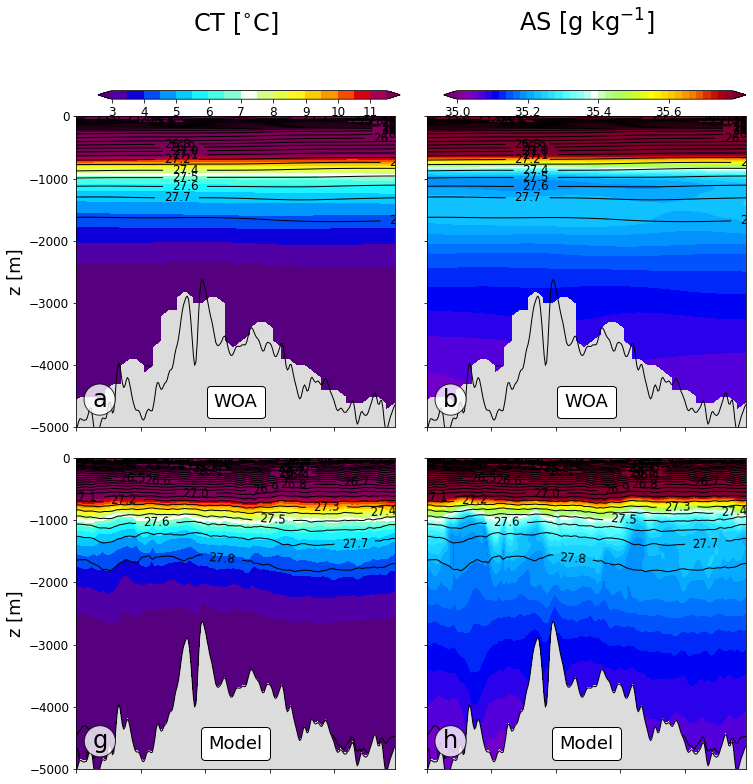

In [227]:

my_cmap_ct=plot.ncview_colormap('jaisnc')
levels_ct= np.arange(3.,12.,0.5)
varunit_ct = 'CT [$^{\circ}$C]'

my_cmap_sa=plot.ncview_colormap('jaisnb')
levels_sa= np.arange(35.,35.8,0.02)
varunit_sa = 'AS [g kg$^{-1}$]'


################################

cbarlabelsize = 6
fontsize0 = 8
fontsize1 = 12
fontsize2 = format(18)
fontsize3 = format(24)
font = {'size'   : fontsize1}
py.rc('font', **font)

################################

fig = py.figure(figsize=(12.0,12.0))

################################

ax1 = fig.add_subplot(221,facecolor='Gainsboro')

joe = ax1.contourf(lon_woa, -depth, CT_woa, levels_ct,extend='both', cmap=my_cmap_ct)
CS2 = ax1.contour(lon_woa, -depth, rho_woa ,np.arange(0,30,0.1),colors = ('k',), linewidths = (1.,))
py.clabel(CS2, fmt = '%2.1f', colors = 'k', fontsize=fontsize1)  ;

ax1.plot(lon_mod[0,:],-topo,'-k',lw=1.)

py.ylabel('z [m]',fontsize=fontsize2)
ax1.xaxis.set_major_formatter( NullFormatter() ); 

ax1.set_ylim([maxdepth, 0.]); py.xlim([xliml, xlimr])

t1 = py.text(0.5, 1.3,  varunit_ct, fontsize=fontsize3,\
             horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes)

at = AnchoredText('WOA',loc='lower center', prop=dict(size=fontsize2), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)



ax4 = fig.add_subplot(223,facecolor='Gainsboro')

joe = ax4.contourf(lon_mod, depth_mod, CT_mod, levels_ct,extend='both', cmap=my_cmap_ct)
CS2 = ax4.contour(lon_mod, depth_mod, rho_mod ,np.arange(0,30,0.1),colors = ('k',), linewidths = (1.,))
py.clabel(CS2, fmt = '%2.1f', colors = 'k', fontsize=fontsize1)  ;

ax4.plot(lon_mod[0,:],-topo,'-k',lw=1.)

py.ylabel('z [m]',fontsize=fontsize2)
ax4.xaxis.set_major_formatter( NullFormatter() ); 

ax4.set_ylim([maxdepth, 0.]); py.xlim([xliml, xlimr])

at = AnchoredText('Model',loc='lower center', prop=dict(size=fontsize2), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax4.add_artist(at)




#######################

#at = AnchoredText(label,loc=4, prop=dict(size=fontsize2), frameon=True, )
#at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#ax.add_artist(at)

cbar_ax = fig.add_axes([0.15, 0.9, 0.35, 0.01])
fig.colorbar(joe, cax=cbar_ax, orientation='horizontal')

################################

ax6 = fig.add_subplot(222,facecolor='Gainsboro')

joe = ax6.contourf(lon_woa, -depth, SA_woa, levels_sa,extend='both', cmap=my_cmap_sa)
CS2 = ax6.contour(lon_woa, -depth, rho_woa ,np.arange(0,30,0.1),colors = ('k',), linewidths = (1.,))
py.clabel(CS2, fmt = '%2.1f', colors = 'k', fontsize=fontsize1)  ;

ax6.plot(lon_mod[0,:],-topo,'-k',lw=1.)

ax6.yaxis.set_major_formatter( NullFormatter() ); 
ax6.xaxis.set_major_formatter( NullFormatter() ); 

ax6.set_ylim([maxdepth, 0.]); py.xlim([xliml, xlimr])

t1 = py.text(0.5, 1.3,  varunit_sa, fontsize=fontsize3,\
             horizontalalignment='center', verticalalignment='center', transform = ax6.transAxes)

at = AnchoredText('WOA',loc='lower center', prop=dict(size=fontsize2), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax6.add_artist(at)

#######################

#######################


ax9 = fig.add_subplot(224,facecolor='Gainsboro')

joe = ax9.contourf(lon_mod, depth_mod, SA_mod, levels_sa,extend='both', cmap=my_cmap_sa)
CS2 = ax9.contour(lon_mod, depth_mod, rho_mod ,np.arange(0,30,0.1),colors = ('k',), linewidths = (1.,))
py.clabel(CS2, fmt = '%2.1f', colors = 'k', fontsize=fontsize1)  ;

ax9.plot(lon_mod[0,:],-topo,'-k',lw=1.)

ax9.yaxis.set_major_formatter( NullFormatter() ); 
ax9.xaxis.set_major_formatter( NullFormatter() ); 

ax9.set_ylim([maxdepth, 0.]); py.xlim([xliml, xlimr])

at = AnchoredText('Model',loc='lower center', prop=dict(size=fontsize2), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax9.add_artist(at)



################################

#at = AnchoredText(label,loc=4, prop=dict(size=fontsize2), frameon=True, )
#at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#ax.add_artist(at)

cbar_ax = fig.add_axes([0.1+0.45, 0.9, 0.35, 0.01])
fig.colorbar(joe, ticks=[35,35.2,35.4, 35.6, 35.8],cax=cbar_ax, orientation='horizontal')

#######################

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)

ax1.text(.05,.05,'a', fontsize=fontsize3,  horizontalalignment='left', verticalalignment='bottom',\
        bbox=props, transform=ax1.transAxes)
ax4.text(.05,.05,'g', fontsize=fontsize3,  horizontalalignment='left', verticalalignment='bottom',\
        bbox=props, transform=ax4.transAxes)
ax6.text(.05,.05,'b', fontsize=fontsize3,  horizontalalignment='left', verticalalignment='bottom',\
        bbox=props, transform=ax6.transAxes)
ax9.text(.05,.05,'h', fontsize=fontsize3,  horizontalalignment='left', verticalalignment='bottom',\
        bbox=props, transform=ax9.transAxes)


#######################

plt.subplots_adjust(wspace=0.1,hspace=0.1)


########################################################################
py.savefig(folder + 'sections_' + season + '.pdf',magnification='auto', bbox_inches='tight',transparence='true'); 

#py.savefig(folder + 'sections_' + season + '.png',magnification='auto', dpi=200,bbox_inches='tight',transparence='true'); py.clf()



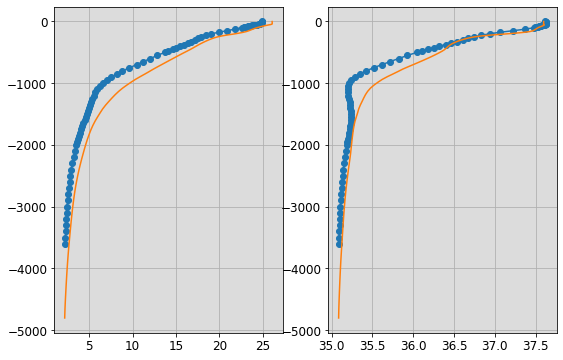

In [228]:
################################

fig = py.figure(figsize=(9.0,6.0))

################################

ax1 = fig.add_subplot(121,facecolor='Gainsboro')

joe = ax1.plot(CT_woa[:,CT_woa.shape[1]//2-1], -depth ,'-o')
joe = ax1.plot(CT_mod[:,CT_mod.shape[1]//2], depth_mod[:,iy] )
ax1.grid()

################################

ax2 = fig.add_subplot(122,facecolor='Gainsboro')

joe = ax2.plot(SA_woa[:,CT_woa.shape[1]//2-1], -depth ,'-o')
joe = ax2.plot(SA_mod[:,CT_mod.shape[1]//2], depth_mod[:,iy] )
ax2.grid()
